### Setup

In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import prettypyplot as pplt
import networkx as nx
from scipy import stats
from analysis_helper import *
from optimize_helper import get_free_energy, load_result_for_molecule

pplt.use_style(true_black=True, sf=False)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams.update({"font.size": 9, "figure.dpi": 220, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})

figpath = Path()
linewidth = 3.40457 # Two column page in inch
linewidth_double = 7.05826  # One column page in inch

### Load data

In [2]:
molecules = load_molecules_list("molecules4.list", default_level=0)
molecules['latent_space'] = molecules.apply(lambda row: load_molecule_latent_space(row), axis=1)
molecules['prior'] = molecules.apply(lambda row: np.nan if row['level'] != 0 else get_molecule_priors(row['name']), axis=1)
nml_molecules = load_molecules_list("molecules-no-ml.list", default_level=2)
nml_molecules['latent_space'] = nml_molecules.apply(lambda row: load_molecule_latent_space(row), axis=1)

In [4]:
latent_space_samples = [load_latent_space_samples(level, 200_000) for level in range(3)]

In [5]:
detailed_latent_space_samples = [load_latent_space_samples(level, 100_000, ['latent_space','node_features','edge_index']) for level in range(3)]

In [6]:
pmf1 = read_xvg("test-simulations/pmfs/C5_SC5_SX4_X4,0-1_0-2_0-3_1-2/pmf-dipc/bsResult.xvg")
pmf2 = read_xvg("test-simulations/pmfs/C5_SC5_SX4_X4,0-1_0-2_0-3_1-2/pmf-mix/bsResult.xvg")

In [2]:
plain_colvars = parse_colvars_traj("test-simulations/plain")
benz_colvars_low = parse_colvars_traj("test-simulations/TC5_TC5_TC5,0-1_0-2_1-2_1.7p")
molecule_colvars_low = parse_colvars_traj("test-simulations/C4_C6_SC5_TC5,0-2_0-3_1-3_1.7p")
benz_colvars_high = parse_colvars_traj("test-simulations/TC5_TC5_TC5,0-1_0-2_1-2_4.8p")
molecule_colvars_high = parse_colvars_traj("test-simulations/C4_C6_SC5_TC5,0-2_0-3_1-3_4.8p")

In [8]:
uncertainty_data = []
systems = ["water", "MIX", "MIX_interface", "DIPC"]
for dirname in next(os.walk("simulations/test-0"))[1]:
    molecule_data = [dirname]
    for dir_path in [Path("simulations/test-0") / dirname, Path("simulations/level-0") / dirname]:
        for system in systems:
            molecule_data.append(get_free_energy(dir_path / system))
        molecule_data.append(load_result_for_molecule(dir_path))
    uncertainty_data.append(molecule_data)
uncertainty_data = pd.DataFrame(uncertainty_data, columns=["name", *[f"{s}1" for s in systems], 'res1', *[f"{s}2" for s in systems], 'res2'])
for system in [*systems, 'res']:
    uncertainty_data[f"{system}diff"] = uncertainty_data[f"{system}1"] - uncertainty_data[f"{system}2"]
uncertainty_data = uncertainty_data.reindex(columns=["name", *[f"{s}{n}" for s in systems for n in ["1", "2", "diff"]],'res1', 'res2','resdiff'])

### Visualize data

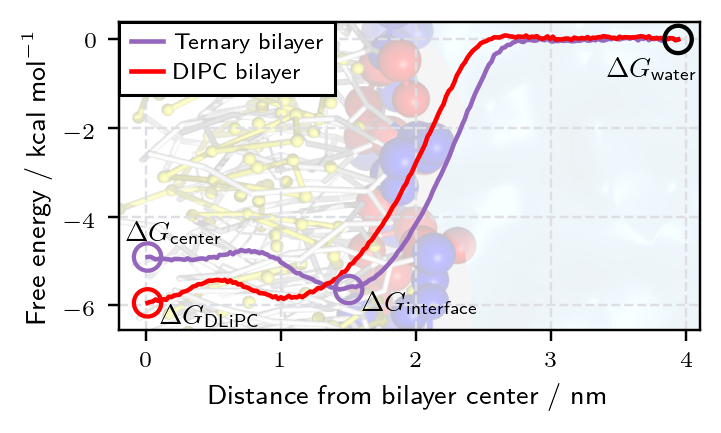

In [9]:
plt.figure(figsize=(linewidth, 2))
background_image = plt.imread(figpath / "membrane-water.png")
plt.imshow(background_image, alpha=0.25, extent=[-0.5, 9, -11, 2], aspect="auto")
plt.plot(pmf2[:, 0], pmf2[:, 1], label="Ternary bilayer", color="tab:purple")
plt.plot(pmf1[:, 0], pmf1[:, 1], label="DIPC bilayer", color='red')
points = [pmf1[0], pmf1[-1], pmf2[0], [1.5, float(pmf2[:,1].min()), 0]]
circle_colors = ["red", "black", "tab:purple", "tab:purple"]
plt.scatter(*np.array(points).T[:2], edgecolors=circle_colors, s=80, facecolors="none", zorder=10, linewidths=1.4)
plt.text(4.08, -0.4, r"$\Delta G_{\text{water}}$", ha="right", va="top")
plt.text(1.6, -6.24, r"$\Delta G_{\text{interface}}$", ha="left", va="bottom")
plt.text(-0.15, -4.65, r"$\Delta G_{\text{center}}$", ha="left", va="bottom")
plt.text(0.1, -6.52, r"$\Delta G_{\text{DLiPC}}$", ha="left", va="bottom")
plt.xlabel("Distance from bilayer center / nm")
plt.ylabel("Free energy / kcal mol$^{-1}$")
plt.xlim(-0.2, 4.1)
plt.ylim(-6.55, 0.4)
plt.legend()
plt.savefig(figpath / "pmf-points.pdf")
plt.show()

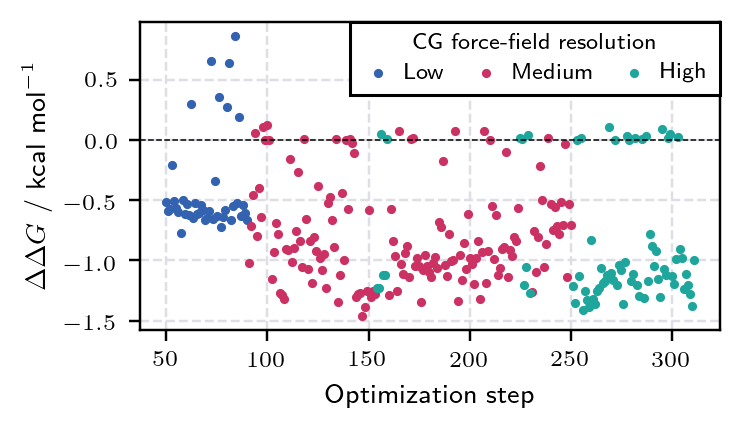

In [10]:
plt.figure(figsize=(linewidth, 2))
scatters = []
for level in range(3):
    level_data = molecules[~np.isnan(molecules['lengthscale']) & (molecules['level'] == level)]
    scat = plt.scatter(level_data.index, level_data['result'], s=4, color=colors[level])
    scatters.append(scat)
lin = plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Optimization step')
plt.ylabel(r"$\Delta\Delta G$ / kcal mol$^{-1}$")
plt.legend(scatters, ['Low', 'Medium', 'High'], title='CG force-field resolution', loc='upper right', ncol=3)
plt.savefig(figpath / 'optimization-progress.pdf')
plt.show()

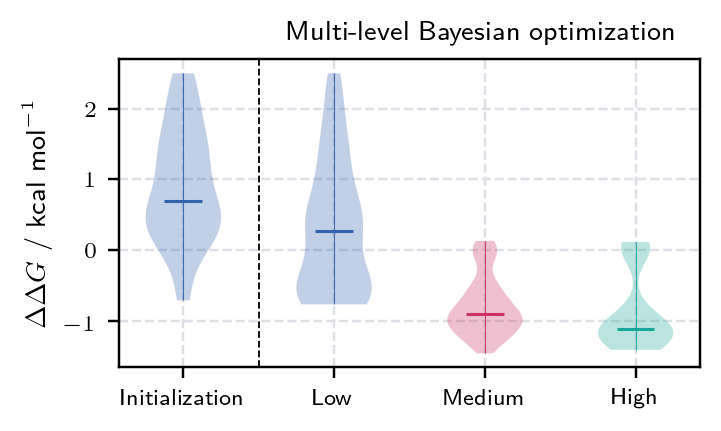

In [4]:
selectors = [np.isnan(molecules['lengthscale']), molecules['level'] == 0, molecules['level'] == 1, molecules['level'] == 2]
datasets = [molecules[selector]['result'] for selector in selectors]
plt.figure(figsize=(linewidth, 2))
violins = plt.violinplot(datasets, showmedians=True, showextrema=True) #, quantiles=[[0.25, 0.75]] * 4)
violins_colorlist = [colors[0], *colors[0:3]]
violins["cbars"].set_color(violins_colorlist)
violins["cmedians"].set_color(violins_colorlist)
#violins["cquantiles"].set_color(np.repeat(violins_colorlist, 2))
#violins["cquantiles"].set_linewidth(0.5)
violins["cmedians"].set_linewidth(1)
violins["cbars"].set_linewidth(0.3)
violins["cmins"].set_visible(False)
violins["cmaxes"].set_visible(False)
for i, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(colors[max(0, i - 1)])
plt.axvline(1.5, color='black', linewidth=0.6, linestyle='--')
plt.ylabel(r"$\Delta\Delta G$ / kcal mol$^{-1}$")
plt.xticks([1, 2, 3, 4], ['Initialization', 'Low', 'Medium', 'High'])
plt.gca().set_title("Multi-level Bayesian optimization", x=0.625, fontdict={'fontsize': 9})
plt.savefig(figpath / "optimization-progress-violin.pdf")
plt.show()

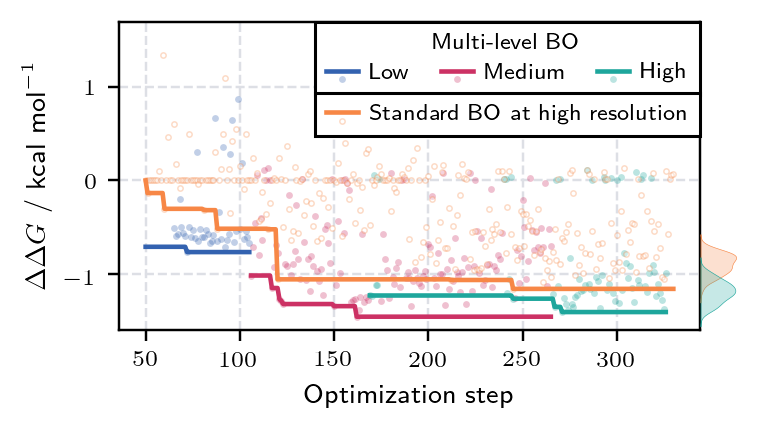

In [26]:
fig, axs = plt.subplots(figsize=(linewidth, 2))
scatters = []
for level in range(3):
    level_data = molecules[~np.isnan(molecules['lengthscale']) & (molecules['level'] == level)]
    scat = axs.scatter(level_data.index+15, level_data['result'], s=5, alpha=0.3, linewidth=0)
    scatters.append(scat)
nmlscat = axs.scatter(nml_molecules['result'].index[50:], nml_molecules['result'][50:], s=3,
            alpha=0.3, color='white', linewidth=0.5, edgecolors=colors[3])
ml1, = axs.plot(datasets[1].index[50-15:] + 15, datasets[1].cummin()[50-15:], color=colors[0])
ml2, = axs.plot(datasets[2].index + 15, datasets[2].cummin(), color=colors[1])
ml3, = axs.plot(datasets[3].index + 15, datasets[3].cummin(), color=colors[2])
nml, = axs.plot(nml_molecules['result'].cummin()[50:], color=colors[3], label="Normal BO")
axs.set(xlabel="Optimization step", ylabel=r"$\Delta\Delta G$ / kcal mol$^{-1}$", ylim=(-1.6, 1.7))
l1 = axs.legend(handles=[(ml1, scatters[0]), (ml2, scatters[1]), (ml3, scatters[2])], labels=['Low', 'Medium', 'High'],
                loc='upper right', ncol=3, columnspacing=1.323, scatteryoffsets=[-0.03], title="Multi-level BO")
axs.legend(handles=[(nml, nmlscat)], labels=['Standard BO at high resolution'],
           loc='upper right', ncol=3, bbox_to_anchor=(0.9999, 0.77), scatteryoffsets=[-0.03])
axs.add_artist(l1)
ax2 = fig.add_axes([0.901, 0.2, 0.05, axs.get_position().height])
top_n = 50
top_ml_results = np.sort(datasets[3].values)[:top_n]
top_sl_results = np.sort(nml_molecules["result"].values)[:top_n]
sns.kdeplot(y=top_sl_results, ax=ax2, color=colors[3], fill=True, linewidth=0.2, bw_adjust=1)
sns.kdeplot(y=top_ml_results, ax=ax2, color=colors[2], fill=True, linewidth=0.2, bw_adjust=1)
ax2.set(xlabel=None, ylabel=None, ylim=axs.get_ylim())
ax2.axis('off')
plt.savefig(figpath / 'comparison-multi-vs-single-level.pdf')
plt.show()

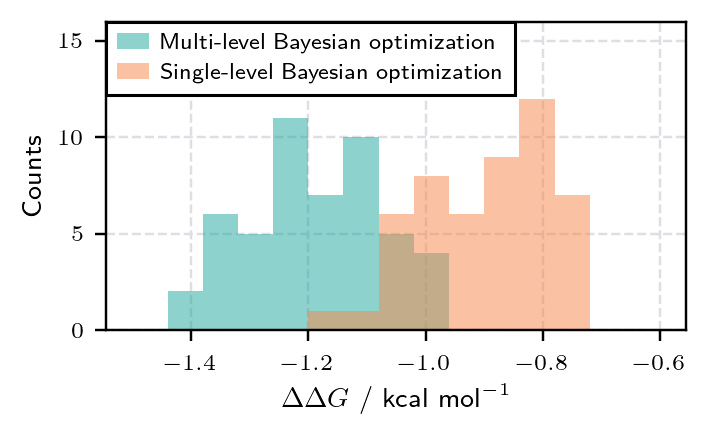

In [ ]:
top_n = 50
top_ml_results = np.sort(datasets[3].values)[:top_n]
top_sl_results = np.sort(nml_molecules["result"].values)[:top_n]
plt.figure(figsize=(linewidth, 2))
bins = np.linspace(-1.5, -0.6, 16)
plt.hist(top_ml_results, bins=bins, alpha=0.5, color=colors[2], label="Multi-level Bayesian optimization")
plt.hist(top_sl_results, bins=bins, alpha=0.5, color=colors[3], label="Single-level Bayesian optimization")
plt.xlabel(r"$\Delta\Delta G$ / kcal mol$^{-1}$")
plt.ylabel("Counts")
plt.ylim(0,16)
plt.legend(loc='upper left')
plt.savefig(figpath / 'top-50-distribution.pdf')
plt.show()

In [20]:
density_estimation = []
for i in range(3):
    kde_factor = [0.1, 0.5, 1.0][i]
    pca, X, Y, Z = transform_latent_space(latent_space_samples[i], kde_factor=kde_factor, padding=[0.05, 0.07, 0.1][i], steps=250)
    density_estimation.append((pca, X, Y, Z))

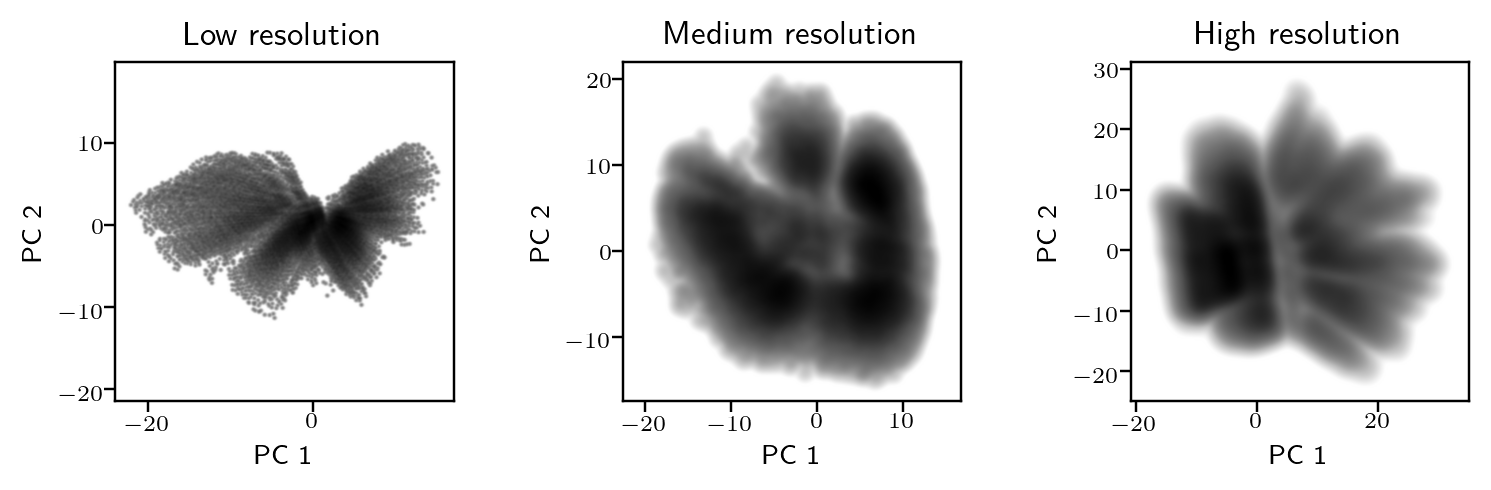

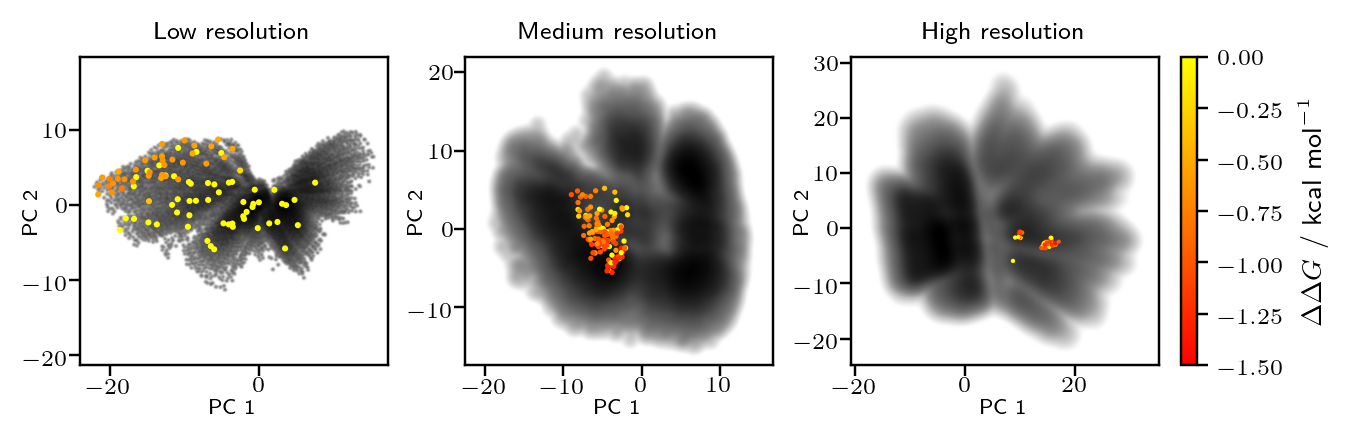

In [21]:
fig_plain, axs_plain = plt.subplots(ncols=3, figsize=(linewidth_double, 2.3), subplot_kw={'box_aspect': 1})
fig, axs = plt.subplots(ncols=3, figsize=(linewidth_double, 2), subplot_kw={'box_aspect': 1})
for i, res_name in enumerate(["Low", "Medium", "High"]):
    pca, X, Y, Z = density_estimation[i]
    imshow = axs[i].imshow(Z+1e-8, origin='lower', cmap='Greys', interpolation='bicubic',
        extent=(X.min(), X.max(), Y.min(), Y.max()), norm=LogNorm(vmin=1e-7), aspect='equal')
    axs_plain[i].imshow(Z+1e-8, origin='lower', cmap='Greys', interpolation='bicubic',
        extent=(X.min(), X.max(), Y.min(), Y.max()), norm=LogNorm(vmin=1e-7), aspect='equal')
    molecules_level = molecules[molecules['level'] == i]
    latent_space = np.array(molecules_level['latent_space'].to_list())
    scatter_colors = np.array(molecules_level['result'].to_list())
    latent_space = pca.transform(latent_space)
    scatter = axs[i].scatter(latent_space[:, 0], latent_space[:, 1], s=[4, 3, 2][i],
        c=scatter_colors, vmin=-1.5, vmax=0, cmap='autumn', edgecolors='none')
    axs[i].set_title(f"{res_name} resolution", fontdict={'fontsize': 8})
    axs[i].set_xlabel("PC 1", labelpad=1, horizontalalignment="center", fontsize=7)
    axs[i].set_ylabel("PC 2", labelpad=-6, horizontalalignment="center", fontsize=7)
    axs[i].tick_params(axis="both", which="major", pad=-0.04)
    axs[i].grid(False)
    axs_plain[i].set(title=f"{res_name} resolution", xlabel="PC 1", ylabel="PC 2")
    axs_plain[i].tick_params(axis="both", which="major", pad=-0.05)
    axs_plain[i].grid(False)
cbar2 = fig.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.02)
cbar2.set_label(r"$\Delta\Delta G$ / kcal mol$^{-1}$")
fig.subplots_adjust(wspace=0.0, right=0.87)
fig.savefig(figpath / 'latent-space-points.pdf', dpi=600)
fig_plain.tight_layout()
fig_plain.savefig(figpath / 'latent-space.pdf', dpi=600)
plt.show()

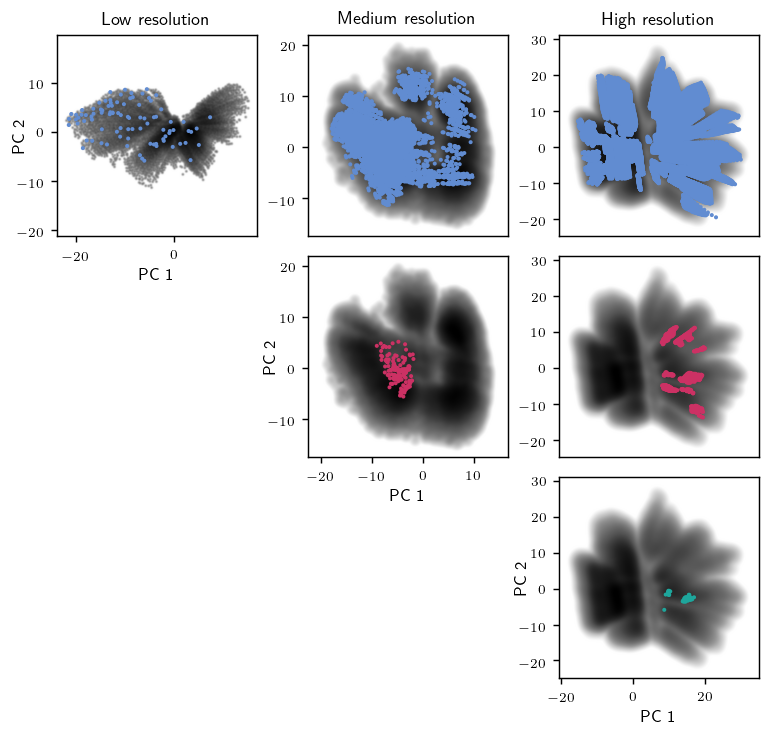

In [22]:
scatter_colors = colors[0:3]
scatter_colors[0] = "#618cd1"
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(linewidth_double, linewidth_double), subplot_kw={'box_aspect': 1}, dpi=130)
for i in range(3):
    for j in range(i, 3):
        pca, X, Y, Z = density_estimation[j]
        axs[i, j].imshow(Z+1e-8, origin='lower', cmap='Greys', interpolation='bicubic',
            extent=(X.min(), X.max(), Y.min(), Y.max()), norm=LogNorm(vmin=1e-7), aspect='equal')
        axs[i, j].grid(False)
        if j == i:
            latent_space = pca.transform(np.array(molecules[molecules['level'] == j]['latent_space'].to_list()))
            axs[i, j].scatter(latent_space[:, 0], latent_space[:, 1], s=5, color=scatter_colors[i], edgecolors='none')
            axs[i, j].xaxis.set_tick_params(labelbottom=True)
            axs[i, j].set(xlabel="PC 1")
            axs[i, j].set_ylabel("PC 2", labelpad=-6, horizontalalignment="center")
        if j == i + 1:
            child_latent_space = get_child_latent_spaces(molecules[molecules['level'] == i]['name'], i)
            child_latent_space = pca.transform(child_latent_space)
            axs[i, j].scatter(child_latent_space[:, 0], child_latent_space[:, 1], s=5, color=scatter_colors[i], edgecolors='none', rasterized=i==0)
            axs[i, j].set_xticks([])
        if j == i + 2:
            grandchild_latent_space = get_grandchild_latent_spaces(molecules[molecules['level'] == i]['name'], i)
            grandchild_latent_space = pca.transform(grandchild_latent_space)
            #_, Xgc, Ygc, Zgc = transform_latent_space(grandchild_latent_space, 0.2, pca=pca)
            axs[i, j].scatter(grandchild_latent_space[:, 0], grandchild_latent_space[:, 1], s=5, color=scatter_colors[i], edgecolors='none', rasterized=True)
            #Zgct = np.where(Zgc[..., None] > 0.00001, [97, 140, 209, 255], [0, 0, 0, 0])
            #axs[i, j].imshow(Zgct, origin='lower', interpolation='bicubic',
            #   extent=(Xgc.min(), Xgc.max(), Ygc.min(), Ygc.max()), aspect='equal')
            axs[i, j].set_xticks([])
    for j in range(0,i):
        axs[i, j].axis('off')
    axs[0,i].set_title(f"{['Low', 'Medium', 'High'][i]} resolution", fontsize=10)
fig.subplots_adjust(hspace=0.1)
plt.savefig(figpath / 'latent-space-mapping.pdf', dpi=600)
plt.show()

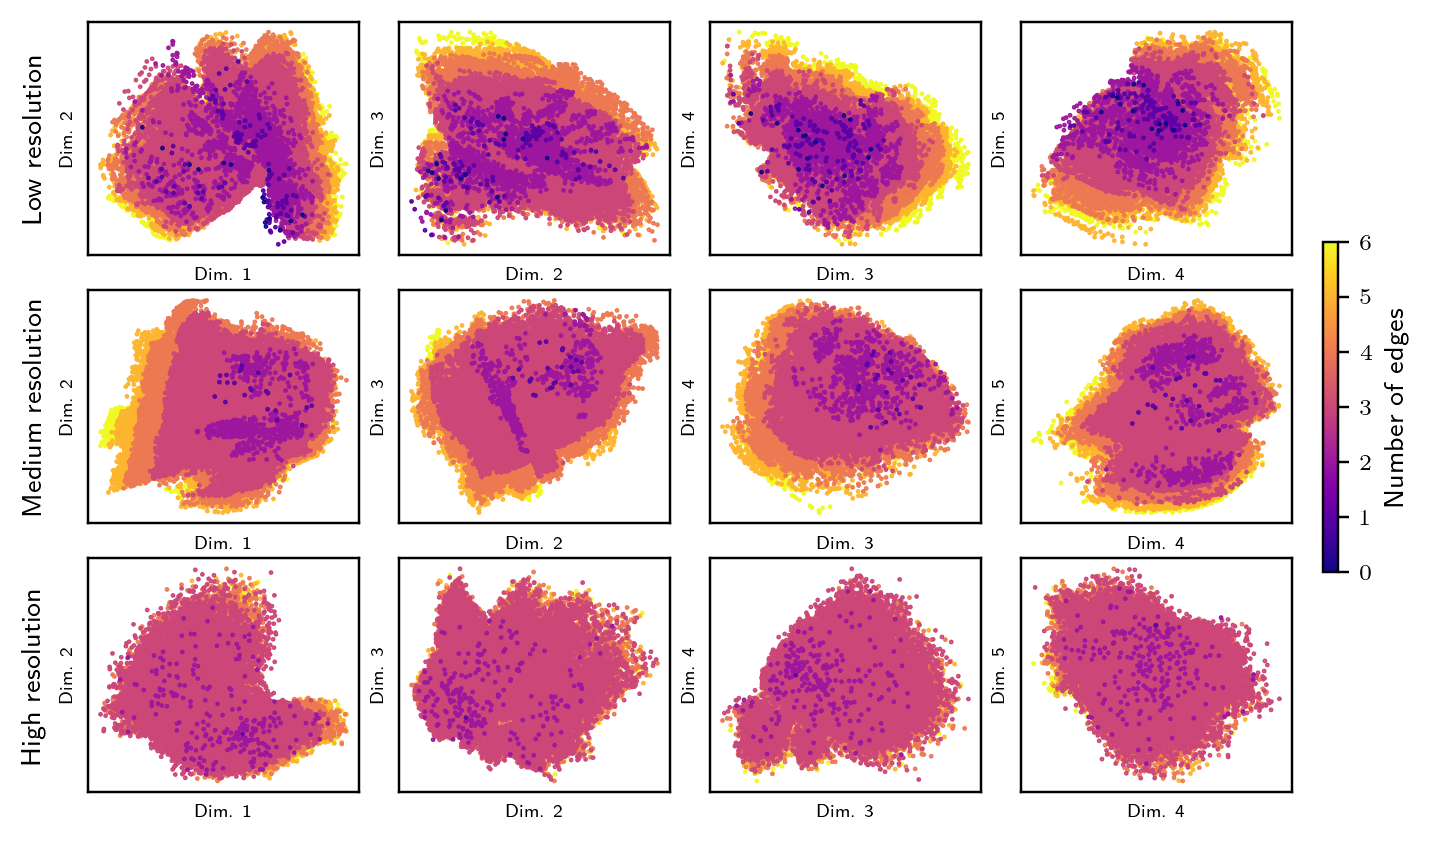

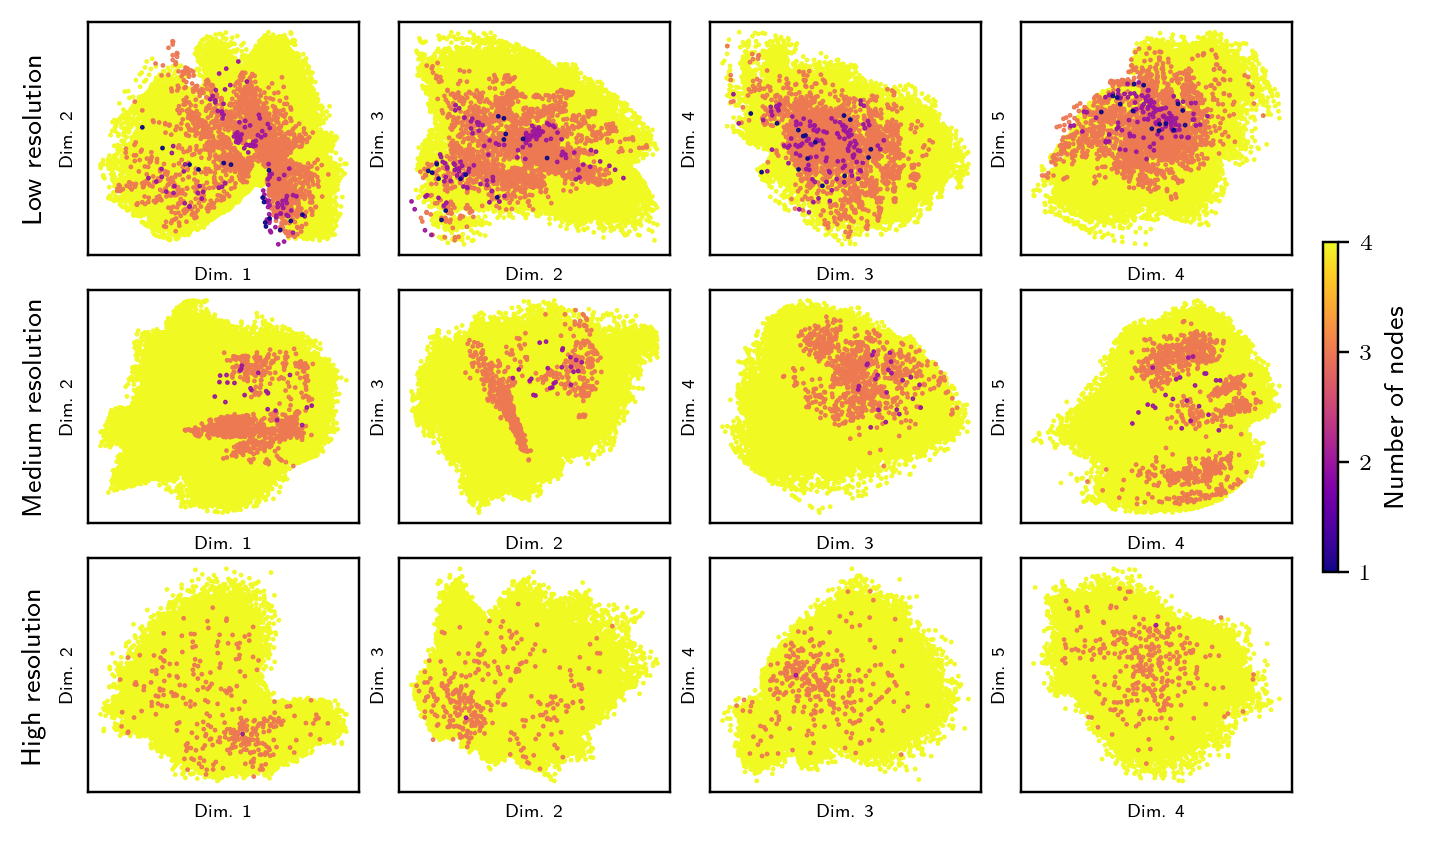

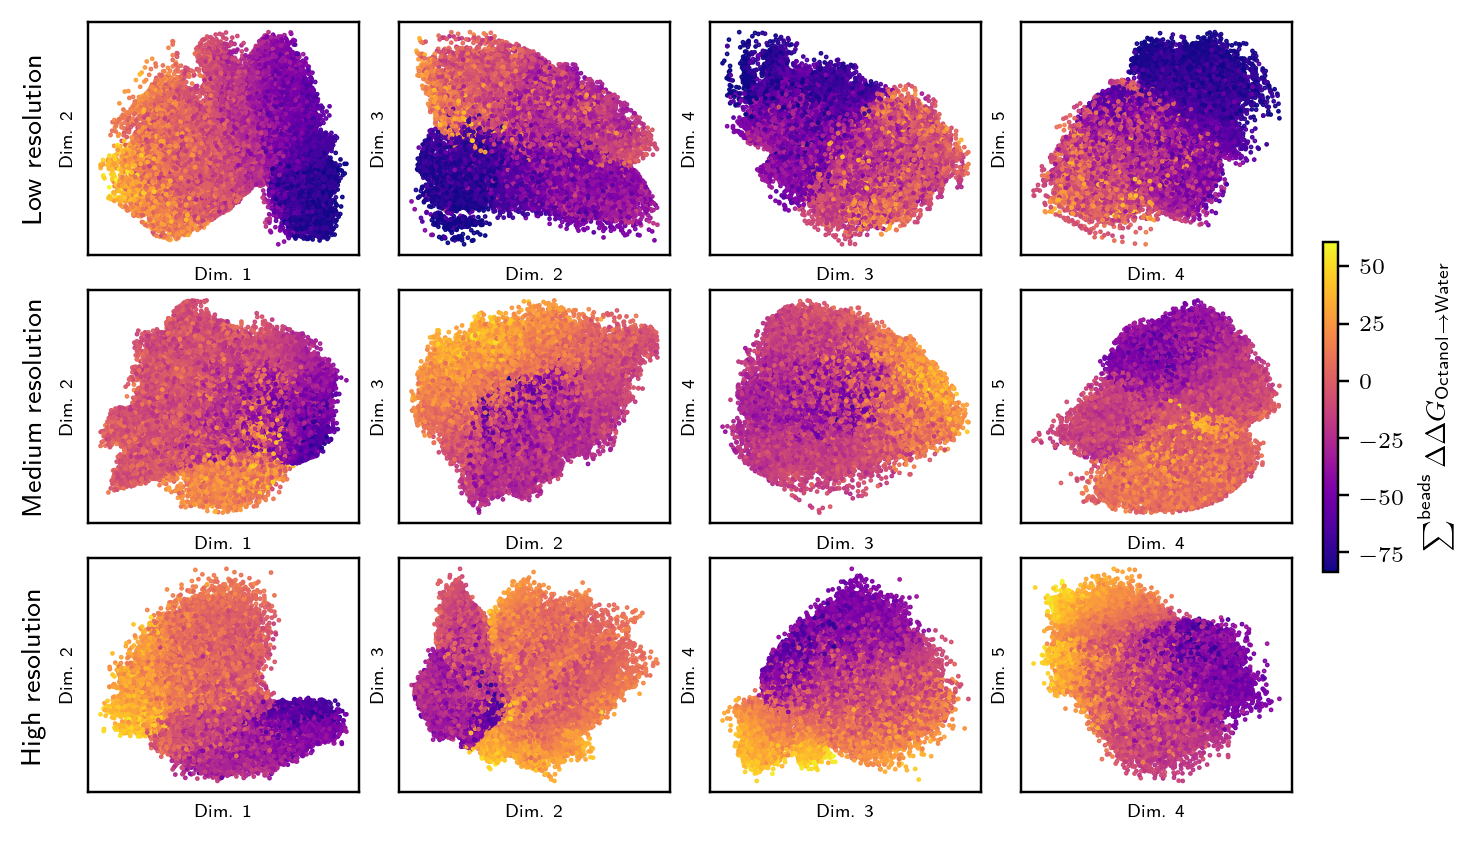

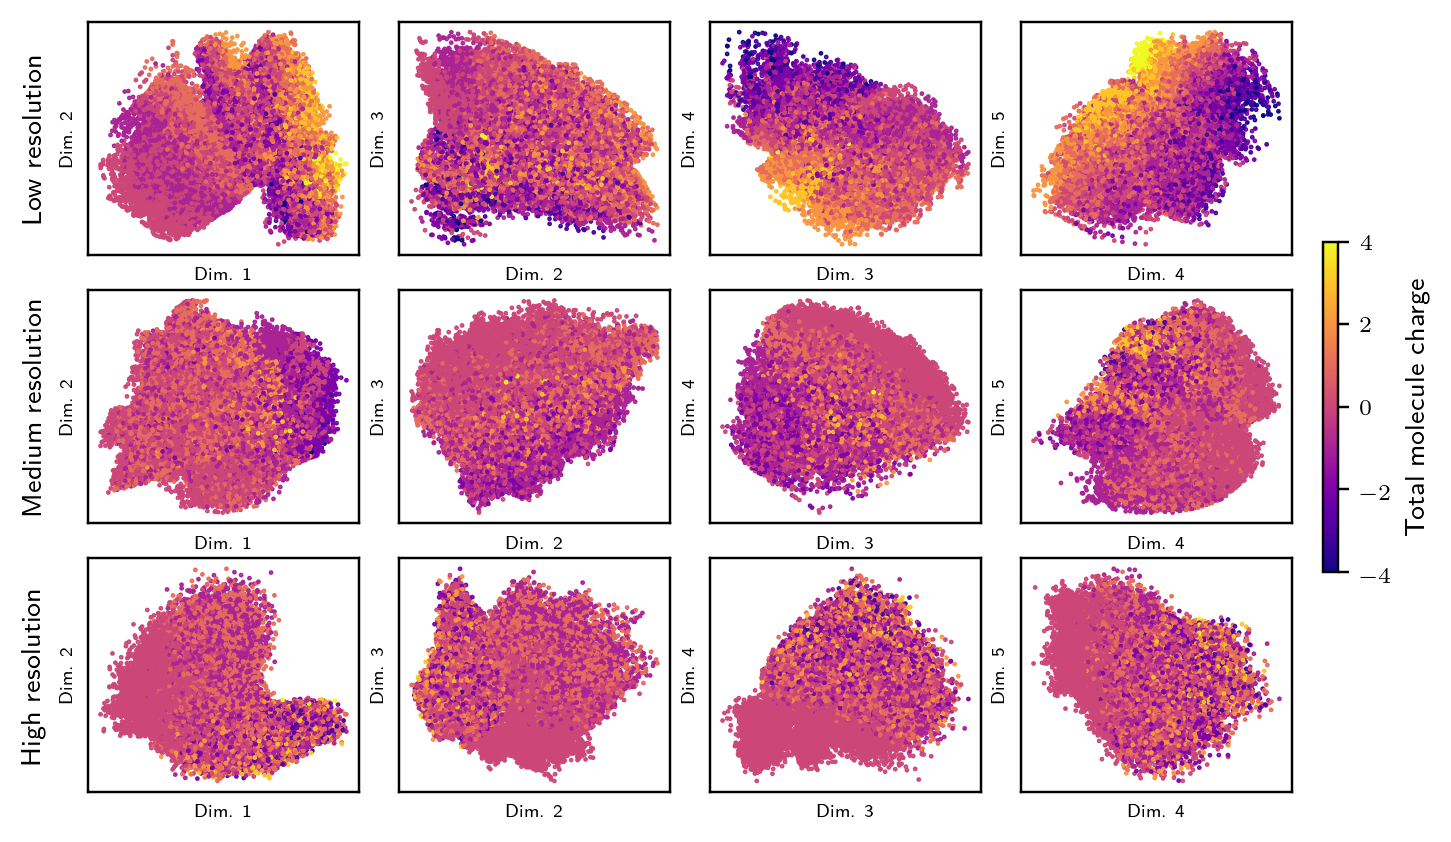

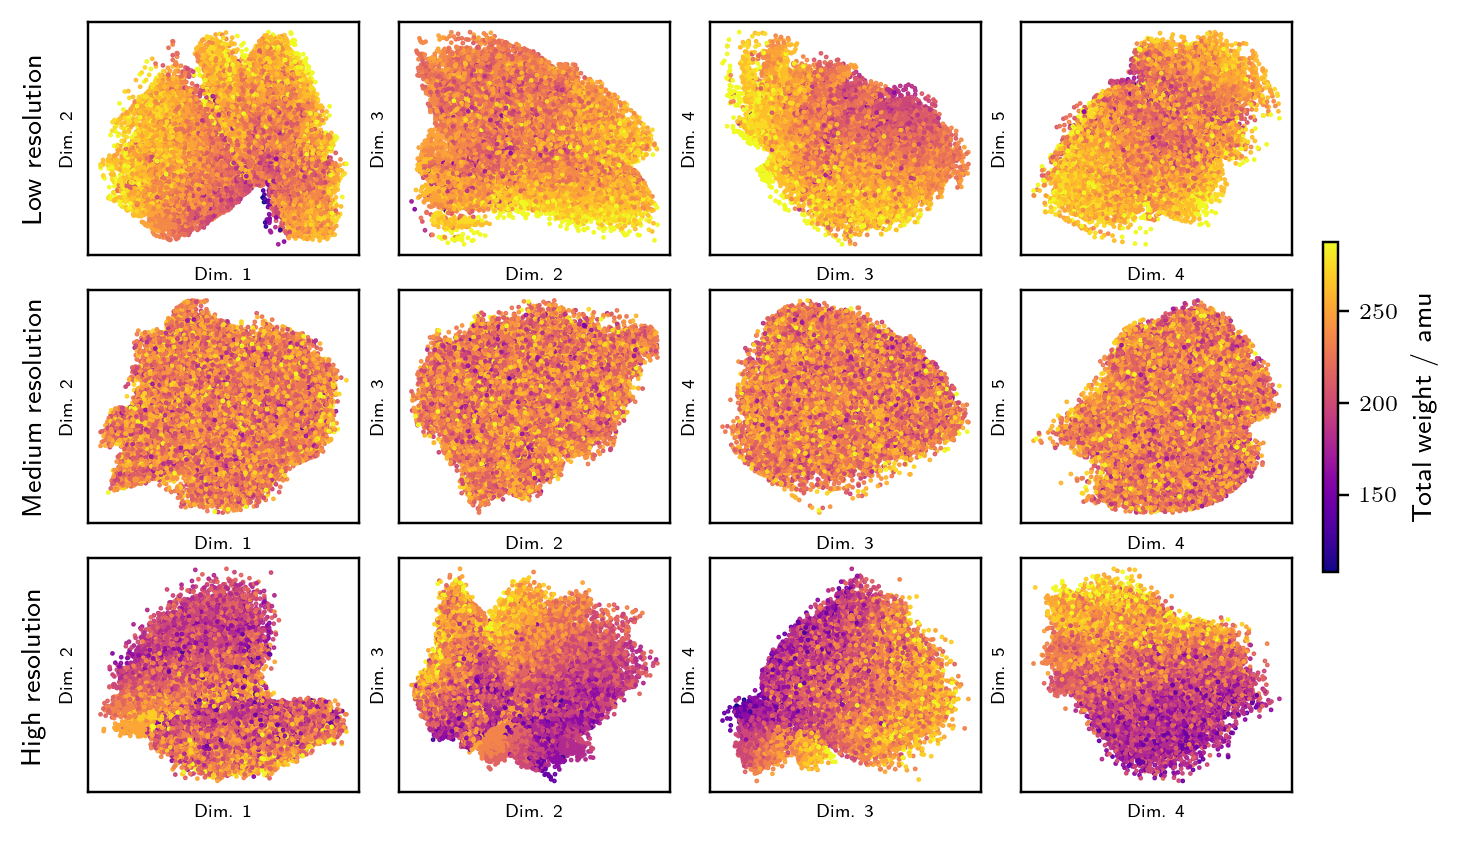

In [23]:
latent_space_coloring_setups = [
    ("Number of edges", 'edges', lambda m: len(m["edge_index"][0])/2, (0, 6), [0, 1, 2, 3, 4, 5, 6], 'value'),
    ("Number of nodes", 'nodes', lambda m: len(m["node_features"]), (1,4), [1,2,3,4], 'value'),
    (r"$\sum^{\text{beads}}\Delta\Delta G_{\text{Octanol}\rightarrow\text{Water}}$", 'octanol', lambda m: np.sum(np.array(m["node_features"])[:,-1]), (None,None),None, 'random'),
    ('Total molecule charge', 'charge', lambda m: np.sum(np.array(m["node_features"])[:,2]-1), (-4,4), [-4, -2, 0, 2, 4], 'random'),
    ('Total weight / amu', 'weight', lambda m: np.sum(np.array([72,54,36])[np.array(m["node_features"])[:,0].astype(int)]), (None, None), None, 'random'),
]
for label, file_name_part, func, limits, bar_ticks, sorting in latent_space_coloring_setups:
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(linewidth_double, 5))
    for level in range(3):
        latent_space = np.array([m["latent_space"] for m in detailed_latent_space_samples[level]])
        ls_color = np.array([func(m) for m in detailed_latent_space_samples[level]])
        index = np.arange(len(latent_space))
        if sorting == 'random':
            np.random.shuffle(index)
        elif 'value' in sorting:
            index = np.argsort(ls_color) if 'asc' in sorting else np.argsort(ls_color)[::-1]
        for dim in range(4):
            scat = axs[level, dim].scatter(latent_space[index, dim], latent_space[index, dim + 1], s=0.3,
                c=ls_color[index], cmap='plasma', vmin=limits[0], vmax=limits[1], rasterized=True)
            axs[level, dim].set_xlabel(f'Dim. {dim + 1}', fontsize=6)
            axs[level, dim].set_ylabel(f'Dim. {dim + 2}', fontsize=6)
            axs[level, dim].set(xticks=[], yticks=[])
        axs[level, 0].text(-0.2, 0.5, f"{['Low', 'Medium', 'High'][level]} resolution",
                        ha='center', va='center', fontsize=9, rotation=90, transform = axs[level, 0].transAxes)
    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    cax = fig.add_axes([0.92, 0.4, 0.01, 0.3])
    fig.colorbar(scat, cax=cax, label=label, orientation='vertical', ticks=bar_ticks)
    plt.savefig(figpath / f"latent-space-properties-{file_name_part}.pdf", dpi=600)
    plt.show()

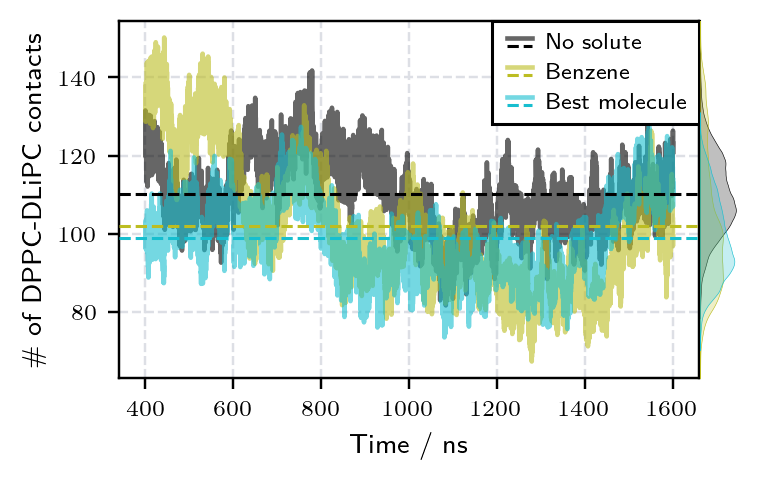

plain: 110.05 ± 9.46
benzene: 101.96 ± 16.44
molecule: 98.79 ± 10.06
T-statistic: 167.873, P-value: 0.000, Significant difference: True


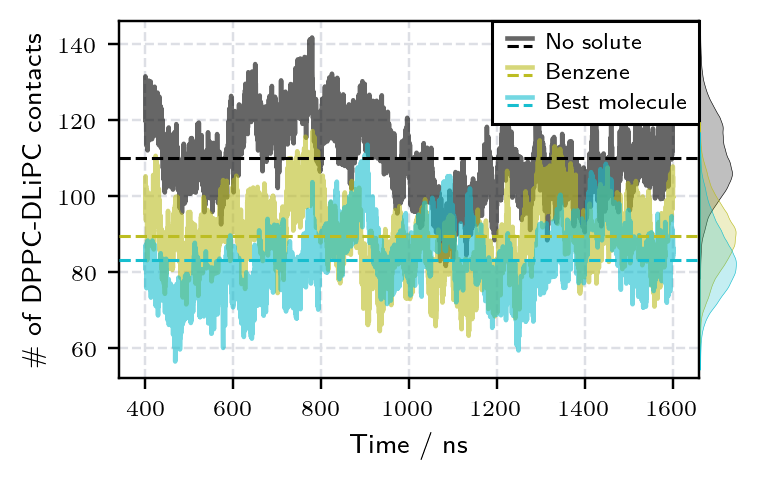

plain: 110.05 ± 9.46
benzene: 89.49 ± 8.58
molecule: 83.33 ± 8.51
T-statistic: 393.431, P-value: 0.000, Significant difference: True


In [4]:
start = 200 * 1000
skip = 35
for name, benz_cols, mol_cols in [('low', benz_colvars_low, molecule_colvars_low), ('high', benz_colvars_high, molecule_colvars_high)]:
    fig, axs = plt.subplots(figsize=(linewidth, 2))
    # x_plain_ss, y_plain_ss = smooth_and_scale(plain_colvars[:, 0], plain_colvars[:, 1:].mean(axis=1), scale=0.02 / 1000)
    x_plain_ss, y_plain_ss = plain_colvars[:, 0] * 0.02 / 1000, plain_colvars[:, 1:].mean(axis=1)
    pl, = axs.plot(x_plain_ss[start::skip], y_plain_ss[start::skip], color='black', alpha=0.6)
    pa = axs.axhline(y_plain_ss[start:].mean(), color='black', linewidth=1, linestyle='--', zorder=10)
    # x_benz_ss, y_benz_ss = smooth_and_scale(benz_cols[:, 0], benz_cols[:, 1:].mean(axis=1), scale=0.02 / 1000)
    x_benz_ss, y_benz_ss = benz_cols[:, 0] * 0.02 / 1000, benz_cols[:, 1:].mean(axis=1)
    bl, = axs.plot(x_benz_ss[start::skip], y_benz_ss[start::skip], color='tab:olive', alpha=0.6)
    ba = axs.axhline(y_benz_ss[start:].mean(), color='tab:olive', linewidth=1, linestyle='--', zorder=10)
    # x_mol_ss, y_mol_ss = smooth_and_scale(mol_cols[:, 0], mol_cols[:, 1:].mean(axis=1), scale=0.02 / 1000)
    x_mol_ss, y_mol_ss = mol_cols[:, 0] * 0.02 / 1000, mol_cols[:, 1:].mean(axis=1)
    ml, = axs.plot(x_mol_ss[start::skip], y_mol_ss[start::skip], label='Best molecule', color='tab:cyan', alpha=0.6)
    ma = axs.axhline(y_mol_ss[start:].mean(), color='tab:cyan', linewidth=1, linestyle='--', zorder=10)
    axs.set(xlabel="Time / ns", ylabel="\# of DPPC-DLiPC contacts")
    axs.legend([(pl, pa), (bl, ba), (ml, ma)], ["No solute", "Benzene", "Best molecule"], loc='upper right', handler_map={tuple: HandlerTupleVertical()})
    plt.subplots_adjust(top=1.01)
    ax2 = fig.add_axes([0.901, 0.2, 0.05, axs.get_position().height])
    sns.kdeplot(y=y_plain_ss[start:], ax=ax2, color='black', fill=True, linewidth=0.2, bw_adjust=0.8)
    sns.kdeplot(y=y_benz_ss[start:], ax=ax2, color='tab:olive', fill=True, linewidth=0.2, bw_adjust=0.8)
    sns.kdeplot(y=y_mol_ss[start:], ax=ax2, color='tab:cyan', fill=True, linewidth=0.2, bw_adjust=0.8)
    ax2.set(xlabel=None, ylabel=None, ylim=axs.get_ylim())
    ax2.axis('off')
    plt.savefig(figpath / f'contact-count-{name}.pdf')
    plt.show()
    # Analyze averages
    means = [y_plain_ss[start:].mean(), y_benz_ss[start:].mean(), y_mol_ss[start:].mean()]
    stds = [y_plain_ss[start:].std(), y_benz_ss[start:].std(), y_mol_ss[start:].std()]
    for name, mean, std in zip(["plain", "benzene", "molecule"], means, stds):
        print(f"{name}: {mean:.2f} ± {std:.2f}")
    # Perform t-test
    t_stat, p_value = stats.ttest_rel(y_benz_ss[start::], y_mol_ss[start::])
    print(
        f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}, Significant difference: {p_value < 0.05}"
    )

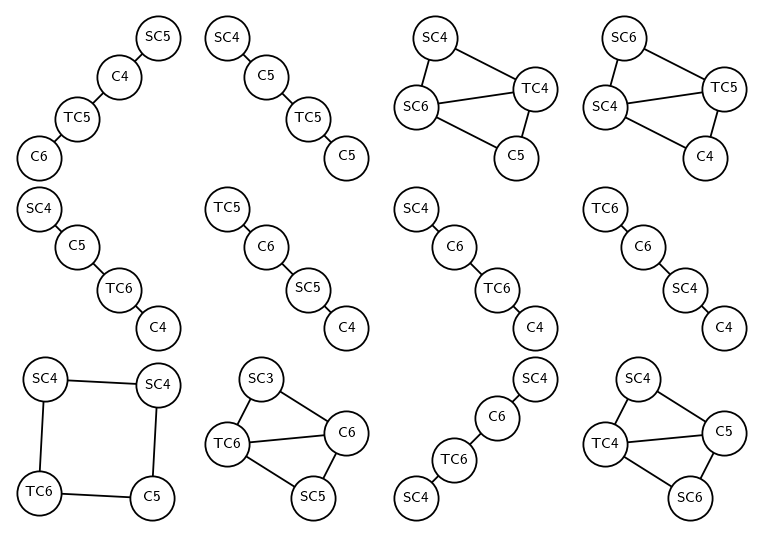

name    result
256           C4_C6_SC5_TC5,0-2_0-3_1-3 -1.410439
259           C5_C5_SC4_TC5,0-3_1-2_1-3 -1.384158
310  C5_SC4_SC6_TC4,0-2_0-3_1-2_1-3_2-3 -1.379093
276  C4_SC4_SC6_TC5,0-1_0-3_1-2_1-3_2-3 -1.364551
262           C4_C5_SC4_TC6,0-3_1-2_1-3 -1.358288
252           C4_C6_SC5_TC5,0-2_1-2_1-3 -1.354760
258           C4_C6_SC4_TC6,0-3_1-2_1-3 -1.325865
261           C4_C6_SC4_TC6,0-2_1-2_1-3 -1.324645
286      C5_SC4_SC4_TC6,0-2_0-3_1-2_1-3 -1.309283
294  C6_SC3_SC5_TC6,0-1_0-2_0-3_1-3_2-3 -1.300888
284          C6_SC4_SC4_TC6,0-2_0-3_1-3 -1.293809
309  C5_SC4_SC6_TC4,0-1_0-2_0-3_1-3_2-3 -1.279233

In [25]:
def draw(molname: str, axs=None):
    g = nx.from_edgelist([list(map(int, l.split('-'))) for l in molname.split(',')[1].split('_')])
    pos = nx.spring_layout(g, k=0.5, iterations=500, threshold=1e-6, seed=11)
    labels = {i: m for i, m in enumerate(molname.split(',')[0].split('_'))}
    nx.draw(g, pos, ax=axs, labels=labels, with_labels=True, node_size=600, node_color='white', edgecolors='black', font_size=8)
    axs.margins(0.15)
best_candidates = molecules[molecules['level'] == 2].sort_values('result').head(12)[['name', 'result']]
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(linewidth*2.2, linewidth/4*3*2.2), subplot_kw={'box_aspect': 1},dpi=130)
for i, name in enumerate(best_candidates['name']):
    draw(name, axs[i//4, i%4])
fig.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()
best_candidates

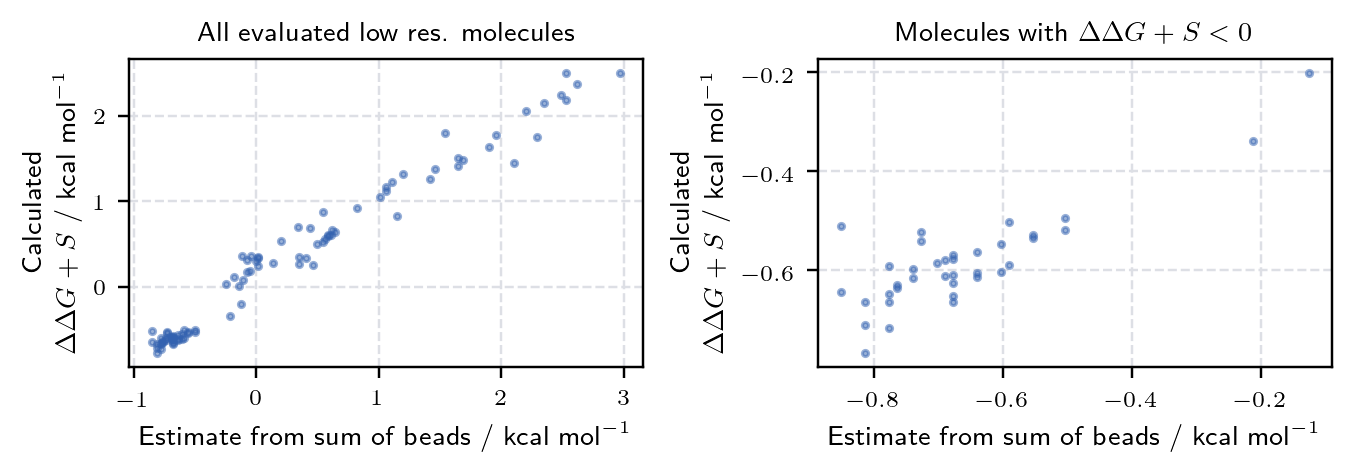

In [26]:
low_res_molecules = molecules[molecules['level'] == 0]
fig, axs = plt.subplots(ncols=2, figsize=(linewidth_double, 2))
axs[0].scatter(low_res_molecules['prior'], low_res_molecules['result'], s=4, color=colors[0], alpha=0.5)
low_low_res_molecules = low_res_molecules[low_res_molecules['result'] < 0]
axs[1].scatter(low_low_res_molecules['prior'], low_low_res_molecules['result'], s=4, color=colors[0], alpha=0.5)
for i in range(2):
    axs[i].set_xlabel("Estimate from sum of beads / kcal mol$^{-1}$")
    axs[i].set_ylabel(r"\begin{center}Calculated\\ $\Delta\Delta G + S$ / kcal mol$^{-1}$\end{center}")
axs[0].set_title("All evaluated low res. molecules", fontsize=9)
axs[1].set_title(r"Molecules with $\Delta\Delta G + S < 0$", fontsize=9)
fig.subplots_adjust(wspace=0.34)
plt.savefig(figpath / 'prior-vs-result.pdf')
plt.show()

        water: method 1: 0.0557 kcal/mol, method 2: 0.0556 kcal/mol
          MIX: method 1: 0.0507 kcal/mol, method 2: 0.0516 kcal/mol
MIX_interface: method 1: 0.0475 kcal/mol, method 2: 0.0480 kcal/mol
         DIPC: method 1: 0.0336 kcal/mol, method 2: 0.0342 kcal/mol
          res: method 1: 0.0241 kcal/mol, method 2: 0.0218 kcal/mol


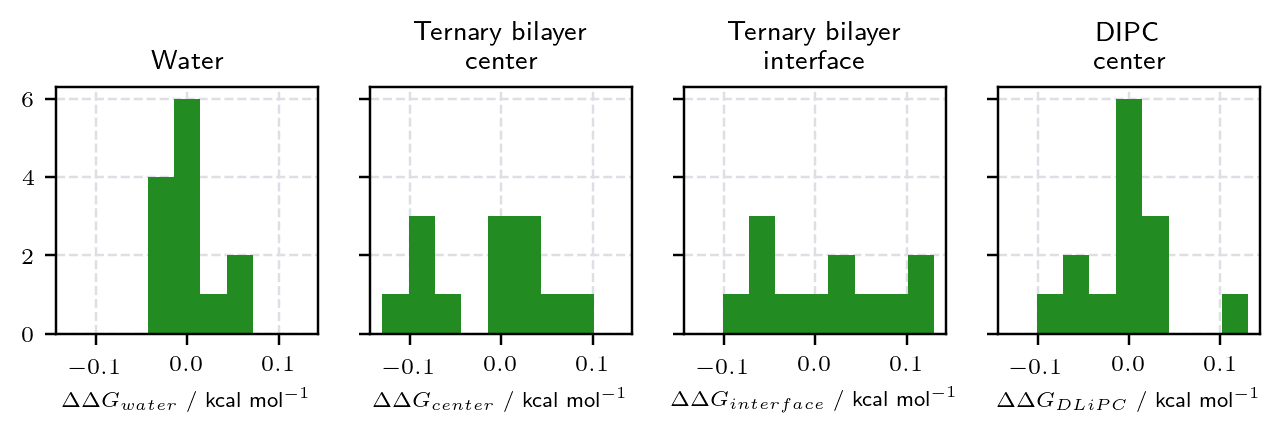

Case 1: 0.0061 kcal/mol
Case 2: 0.0117 kcal/mol
Case 3: 0.0613 kcal/mol
Combined: 0.0627 kcal/mol


name     water1     water2  waterdiff  \
0   C_C_SC_TN,0-1_0-2_0-3_1-2_1-3_2-3   1.675699   1.711574  -0.035875   
1               C_C_SN_SN,0-1_1-3_2-3   3.287808   3.227423   0.060386   
2                C_C_C_SN,0-2_1-2_2-3   1.625875   1.603711   0.022164   
3             C_N_N_N,0-1_0-2_0-3_2-3   7.446074   7.467231  -0.021157   
4                 C_C_C_C,0-1_1-3_2-3  -0.110211  -0.114024   0.003813   
5           C_N_SC_TN,0-1_0-2_1-2_2-3   3.635645   3.645392  -0.009747   
6                    SC_SC_TC,0-1_1-2  -1.883554  -1.895206   0.011653   
7            C_C_N_TC,0-1_0-2_1-2_2-3   2.150123   2.192072  -0.041949   
8                   C_C_C,0-1_0-2_1-2   0.351444   0.299123   0.052322   
9     SN_TC_TN_TP,0-1_0-2_1-2_1-3_2-3   5.666914   5.654620   0.012294   
10          C_C_SN_TC,0-1_0-2_1-2_2-3   0.949629   1.218860  -0.269231   
11         P_Q+_Q-_SN,0-2_0-3_1-2_2-3  20.140746  20.157053  -0.016307   
12          C_N_SC_SC,0-1_0-3_1-2_1-3   2.231345   2.223978   0.007367   
13            C_C_N_N,0-1_0-3_1-2_2-3   5.308241   5.301247   0.006994   

        MIX1      MIX2   MIXdiff  MIX_interface1  MIX_interface2  \
0   7.173659  7.261752 -0.088093        7.350003        7.399307   
1   6.141006  6.089085  0.051922        8.297746        8.352585   
2   7.482066  7.475274  0.006792        8.012408        7.980540   
3   7.625487  7.492616  0.132872       11.262650       11.245071   
4   8.878060  8.838837  0.039223        7.621774        7.708660   
5   5.878499  5.854702  0.023796        7.816172        7.875149   
6   3.467683  3.440873  0.026810        2.333241        2.362717   
7   7.420830  7.513667 -0.092837        7.980163        7.904253   
8   7.302137  7.218802  0.083334        6.593666        6.485213   
9   1.117709  1.170520 -0.052811             NaN             NaN   
10  6.437722  6.429728  0.007995        6.695901        6.631578   
11  3.556868  3.556700  0.000168             NaN             NaN   
12  7.436791  7.552511 -0.115720        7.884891        7.777049   
13  8.414591  8.495568 -0.080977       10.899860       10.903728   

    MIX_interfacediff     DIPC1     DIPC2  DIPCdiff      res1      res2  \
0           -0.049304  7.996381  7.999191 -0.002810  0.029391  0.022926   
1           -0.054840  7.083234  7.146992 -0.063758  0.359457  0.377250   
2            0.031868  8.310342  8.297321  0.013021  0.088390  0.084211   
3            0.017579  8.724037  8.725059 -0.001023  0.500000  0.500000   
4           -0.086885  9.555355  9.521852  0.033503 -0.677296 -0.683016   
5           -0.058977  6.772962  6.849762 -0.076800  0.322946  0.336741   
6           -0.029476  3.958531  3.959971 -0.001440 -0.490849 -0.519098   
7            0.075911  8.246329  8.224197  0.022132  0.093222  0.065098   
8            0.108453  7.806702  7.831937 -0.025235 -0.504565 -0.613135   
9                 NaN  2.218143  2.211372  0.006771  0.863936  0.858728   
10           0.064323  7.178468  7.249794 -0.071326  0.043030  0.033642   
11                NaN  6.316725  6.206405  0.110320  1.826710  1.828028   
12           0.107842  8.235795  8.240981 -0.005187  0.074683  0.037423   
13          -0.003868  9.470396  9.443009  0.027387  0.414212  0.401360   

     resdiff  
0   0.006465  
1  -0.017794  
2   0.004179  
3   0.000000  
4   0.005720  
5  -0.013796  
6   0.028249  
7   0.028125  
8   0.108569  
9   0.005208  
10  0.009388  
11 -0.001318  
12  0.037260  
13  0.012851

In [27]:
for system in [*systems, 'res']:
    deviations = uncertainty_data[f"{system}diff"]
    stddev = np.sqrt(np.sum(deviations**2) / (2 * len(deviations.dropna()) - 1))
    stddev2 = deviations.std() / np.sqrt(2)
    print(f"{system:>13}: method 1: {stddev:.4f} kcal/mol, method 2: {stddev2:.4f} kcal/mol")
fig, axs = plt.subplots(ncols=4, figsize=(linewidth_double, 1.6), sharex=True, sharey=True)
bins = np.linspace(-0.13, 0.13, 10)
for i, system in enumerate(systems):
    axs[i].hist(uncertainty_data[f"{system}diff"].dropna(), bins=bins, color='forestgreen')
    axs[i].set_title(["Water", 'Ternary bilayer\ncenter', 'Ternary bilayer\ninterface', 'DIPC\ncenter'][i], fontsize=9)
    axs[i].set_xlabel(fr"$\Delta\Delta G_{{{['water','center','interface','DLiPC'][i]}}}$ / kcal mol$^{{-1}}$", fontdict={'fontsize': 7})
plt.savefig(figpath / 'uncertainty-estimation.pdf')
plt.show()
unc_case1 = np.sqrt(0.056**2 + 0.051**2) / 12.5
print(f"Case 1: {unc_case1:.4f} kcal/mol")
unc_case2 = np.sqrt(0.048**2 + 0.051**2) / 6
print(f"Case 2: {unc_case2:.4f} kcal/mol")
unc_case3 = np.sqrt(0.034**2 + 0.051**2)
print(f"Case 3: {unc_case3:.4f} kcal/mol")
print(f"Combined: {np.sqrt(unc_case1**2+unc_case2**2+unc_case3**2):.4f} kcal/mol")
uncertainty_data